# Workshop Notebook 4: Observability Part 2 - Drift Detection

In the previous notebook you learned how to add simple validation rules to a pipeline, to monitor whether outputs (or inputs) stray out of some expected range. In this notebook, you will monitor the *distribution* of the pipeline's predictions to see if the model, or the environment that it runs it, has changed.

## Preliminaries

In the blocks below we will preload some required libraries.

For convenience, the following `helper functions` are defined to retrieve previously created workspaces, models, and pipelines:

* `get_workspace(name, client)`: This takes in the name and the Wallaroo client being used in this session, and returns the workspace matching `name`.  If no workspaces are found matching the name, raises a `KeyError` and returns `None`.
* `get_model_version(model_name, workspace)`: Retrieves the most recent model version from the model matching the `model_name` within the provided `workspace`.  If no model matches that name, raises a `KeyError` and returns `None`.
* `get_pipeline(pipeline_name, workspace)`: Retrieves the most pipeline from the workspace matching the `pipeline_name` within the provided `workspace`.  If no model matches that name, raises a `KeyError` and returns `None`.


In [1]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import json
import datetime
import time

# used for unique connection names

import string
import random

In [2]:
## convenience functions from the previous notebooks

# return the workspace called <name> through the Wallaroo client.
def get_workspace(name, client):
    workspace = None
    for ws in client.list_workspaces():
        if ws.name() == name:
            workspace= ws
            return workspace
    # if no workspaces were found
    if workspace==None:
        raise KeyError(f"Workspace {name} was not found.")
    return workspace


# returns the most recent model version in a workspace for the matching `model_name`
def get_model_version(model_name, workspace):
    modellist = workspace.models()
    model_version = [m.versions()[-1] for m in modellist if m.name() == model_name]
    # if no models match, return None
    if len(modellist) <= 0:
        raise KeyError(f"Model {mname} not found in this workspace")
        return None
    return model_version[0]

# get a pipeline by name in the workspace
def get_pipeline(pipeline_name, workspace):
    plist = workspace.pipelines()
    pipeline = [p for p in plist if p.name() == pipeline_name]
    if len(pipeline) <= 0:
        raise KeyError(f"Pipeline {pipeline_name} not found in this workspace")
        return None
    return pipeline[0]


## Login to Wallaroo

Retrieve the previous workspace, model versions, and pipelines used in the previous notebook.

In [3]:
wl = wallaroo.Client()

wl = wallaroo.Client()

wallarooPrefix = "doc-test."
wallarooSuffix = "wallaroocommunity.ninja"

wl = wallaroo.Client(api_endpoint=f"https://{wallarooPrefix}api.{wallarooSuffix}", 
                    auth_endpoint=f"https://{wallarooPrefix}keycloak.{wallarooSuffix}", 
                    auth_type="sso")

In [4]:
## blank space to log in 

# wl = wallaroo.Client()

# retrieve the previous workspace, model, and pipeline version

workspace_name = "workshop-workspace-john-05"

workspace = get_workspace(workspace_name, wl)

# set your current workspace to the workspace that you just created
wl.set_current_workspace(workspace)

# optionally, examine your current workspace
wl.get_current_workspace()

model_name = 'house-price-prime'

prime_model_version = get_model_version(model_name, workspace)

pipeline_name = 'houseprice-estimator'

pipeline = get_pipeline(pipeline_name, workspace)

display(workspace)
display(prime_model_version)
display(pipeline)


{'name': 'workshop-workspace-john-05', 'id': 10, 'archived': False, 'created_by': 'fa780cd9-154a-4456-848b-5934f703fcdb', 'created_at': '2024-03-11T17:58:57.996784+00:00', 'models': [{'name': 'house-price-prime', 'versions': 1, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 3, 11, 17, 58, 59, 18588, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 3, 11, 17, 58, 59, 18588, tzinfo=tzutc())}], 'pipelines': [{'name': 'houseprice-estimator', 'create_time': datetime.datetime(2024, 3, 11, 17, 58, 59, 194422, tzinfo=tzutc()), 'definition': '[]'}]}

{'name': 'house-price-prime', 'version': '6082ad4c-e034-4bb1-a9e7-dc267b149adc', 'file_name': 'xgb_model.onnx', 'image_path': None, 'last_update_time': datetime.datetime(2024, 3, 11, 17, 58, 59, 18588, tzinfo=tzutc())}

name,houseprice-estimator
created,2024-03-11 17:58:59.194422+00:00
last_updated,2024-03-12 14:20:36.802000+00:00
deployed,True
tags,
versions,"88fa845d-0592-44df-8c23-3c8a5d888918, 77ad5fac-733b-40aa-8471-2b623731a1c2, e2c02684-b936-4eaa-ae22-16cc425ac1a7, 90680a22-b46c-4c4c-9c93-cecf87860321, d7ae395c-c5db-41aa-abfa-37aab4050924, e2c920d7-f993-4974-86ff-fdb5230ff590"
steps,house-price-prime


Set up the pipeline with the single model step as was done in notebook 1, then deploy it.

## Monitoring for Drift: Shift Happens. 

In machine learning, you use data and known answers to train a model to make predictions for new previously unseen data. You do this with the assumption that the future unseen data will be similar to the data used during training: the future will look somewhat like the past.
But the conditions that existed when a model was created, trained and tested can change over time, due to various factors.

A good model should be robust to some amount of change in the environment; however, if the environment changes too much, your models may no longer be making the correct decisions. This situation is known as concept drift; too much drift can obsolete your models, requiring periodic retraining.

Let's consider the example we've been working on: home sale price prediction. You may notice over time that there has been a change in the mix of properties in the listings portfolio: for example a dramatic increase or decrease in expensive properties (or more precisely, properties that the model thinks are expensive)

Such a change could be due to many factors: a change in interest rates; the appearance or disappearance of major sources of employment; new housing developments opening up in the area. Whatever the cause, detecting such a change quickly is crucial, so that the business can react quickly in the appropriate manner, whether that means simply retraining the model on fresher data, or a pivot in business strategy.

In Wallaroo you can monitor your housing model for signs of drift through the model monitoring and insight capability called Assays. Assays help you track changes in the environment that your model operates within, which can affect the model’s outcome. It does this by tracking the model’s predictions and/or the data coming into the model against an **established baseline**. If the distribution of monitored values in the current observation window differs too much from the baseline distribution, the assay will flag it. The figure below shows an example of a running scheduled assay.


![](../images/wallaroo-model-insights-reference_35_0.png)

**Figure:** A daily assay that's been running for a month. The dots represent the difference between the distribution of values in the daily observation window, and the baseline. When that difference exceeds the specified threshold (indicated by a red dot) an alert is set.

This next set of exercises will walk you through setting up an assay to monitor the predictions of your house price model, in order to detect drift.

### NOTE

An assay is a monitoring process that typically runs over an extended, ongoing period of time. For example, one might set up an assay that every day monitors the previous 24 hours' worth of predictions and compares it to a baseline. For the purposes of these exercises, we'll be compressing processes what normally would take hours or days into minutes.

<hr/>

### Assay DataSet Exercise

Because assays are designed to detect changes in distributions, let's try to set up data with different distributions to test with. Take your houseprice data and create two sets: a set with lower prices, and a set with higher prices. You can split however you choose.

The idea is we will pretend that the set of lower priced houses represent the "typical" mix of houses in the housing portfolio at the time you set your baseline; you will introduce the higher priced houses later, to represent an environmental change when more expensive houses suddenly enter the market.

* If you are using the pre-provided models to do these exercises, you can use the provided data sets `lowprice.df.json` and `highprice.df.json`.  This is to establish our baseline as a set of known values, so the higher prices will trigger our assay alerts.

```python
lowprice_data = pd.read_json('./data/lowprice.df.json')
highprice_data = pd.read_json('./data/highprice.df.json')
```

Note that the data in these files are already in the form expected by the models, so you don't need to use the `get_singleton` or `get_batch` convenience functions to infer.

At the end of this exercise, you should have two sets of data to demonstrate assays. In the discussion below, we'll refer to these sets as `lowprice_data` and `highprice_data`.


We will use this data to set up some "historical data" in the house price prediction pipeline that you build in the assay exercises.


## Generate Sample Data

Before creating the assays, we will retrieve some sample data.  The following files are provided by the instructor, and at this point inferences are run in the same workspace and pipeline that was retrieved.

We'll retrieve the following variables for use in our assay generation:


* `small_results_baseline`:  Used to create the baseline from the numpy values from sample inferences.
* `assay_baseline_start`: When to start the baseline from the inference history.
* `assay_baseline_end`: When to end the baseline from the inference history.
* `assay_window_start`: When to start the assay window period for assay samples.

In [4]:
# not needed for 2023.2
import numpy

baseline_numpy = numpy.load('./small_results_baseline.npy')

In [8]:
# read the assay baseline start datetime

with open('./assay_baseline_start', 'r') as file:
    assay_baseline_start = datetime.datetime.strptime(file.read(), "%d-%b-%Y (%H:%M:%S.%f)")

# read the assay baseline end datetime

with open('./assay_baseline_end', 'r') as file:
    assay_baseline_end = datetime.datetime.strptime(file.read(), "%d-%b-%Y (%H:%M:%S.%f)")

# read the assay window start datetime

with open('./assay_window_start', 'r') as file:
    assay_window_start = datetime.datetime.strptime(file.read(), "%d-%b-%Y (%H:%M:%S.%f)")
assay_window_start

datetime.datetime(2024, 3, 11, 19, 16, 0, 149220)

## Model Insights via the Wallaroo Dashboard SDK

Assays generated through the Wallaroo SDK can be previewed, configured, and uploaded to the Wallaroo Ops instance.  The following is a condensed version of this process.  For full details see the [Wallaroo SDK Essentials Guide: Assays Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-assays/) guide.

Model drift detection with assays using the Wallaroo SDK follows this general process.

* Define the Baseline: From either historical inference data for a specific model in a pipeline, or from a pre-determine array of data, a **baseline** is formed.
* Assay Preview:  Once the baseline is formed, we **preview the assay** and configure the different options until we have the the best method of detecting environment or model drift.
* Create Assay:  With the previews and configuration complete, we **upload** the assay.  The assay will perform an analysis on a regular scheduled based on the configuration.
* Get Assay Results:  Retrieve the analyses and use them to detect model drift and possible sources.
* Pause/Resume Assay:  Pause or restart an assay as needed.

### Define the Baseline

Assay baselines are defined with the [`wallaroo.client.build_assay`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/client/#Client.build_assay) method. Through this process we define the baseline from either a range of dates or pre-generated values.

`wallaroo.client.build_assay` take the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_name** | *String* (*Required*) - required | The name of the assay.  Assay names **must** be unique across the Wallaroo instance. |
| **pipeline** | *wallaroo.pipeline.Pipeline* (*Required*) | The pipeline the assay is monitoring. |
| **model_name** | *String* (*Required*)  | The name of the model to monitor.
| **iopath** | *String* (*Required*) | The input/output data for the model being tracked in the format `input/output field index`.  Only one value is tracked for any assay.  For example, to track the **output** of the model's field `house_value` at index `0`, the `iopath` is `'output house_value 0`. |
| **baseline_start** | *datetime.datetime* (*Optional*) | The start time for the inferences to use as the baseline.  **Must be included with `baseline_end`.  Cannot be included with `baseline_data`**. |
| **baseline_end** | *datetime.datetime* (*Optional*) | The end time of the baseline window. the baseline. Windows start immediately after the baseline window and are run at regular intervals continuously until the assay is deactivated or deleted.  **Must be included with `baseline_start`.  Cannot be included with `baseline_data`.**. |
| **baseline_data** | *numpy.array* (*Optional*) | The baseline data in numpy array format.  **Cannot be included with either `baseline_start` or `baseline_data`**. |

Baselines are created in one of two ways:

* **Date Range**:  The `baseline_start` and `baseline_end` retrieves the inference requests and results for the pipeline from the start and end period.  This data is summarized and used to create the baseline.
* **Numpy Values**:  The `baseline_data` sets the baseline from a provided numpy array.

#### Define the Baseline Example

This example shows two methods of defining the baseline for an assay:

* `"assays from date baseline"`: This assay uses historical inference requests to define the baseline.  This assay is saved to the variable `assay_builder_from_dates`.
* `"assays from numpy"`:  This assay uses a pre-generated numpy array to define the baseline.  This assay is saved to the variable `assay_builder_from_numpy`.

In both cases, the following parameters are used:

| Parameter | Value |
|---|---|
| **assay_name** | `"assays from date baseline"` and `"assays from numpy"` |
| **pipeline** | `mainpipeline`:  A pipeline with a ML model that predicts house prices.  The output field for this model is `variable`. |
| **model_name** | `"houseprice-predictor"` - the model name set during model upload. |
| **iopath** | These assays monitor the model's **output** field **variable** at index 0.  From this, the `iopath` setting is `"output variable 0"`.  |

The difference between the two assays' parameters determines how the baseline is generated.

* `"assays from date baseline"`: Uses the `baseline_start` and `baseline_end` to set the time period of inference requests and results to gather data from.
* `"assays from numpy"`:  Uses a pre-generated numpy array as for the baseline data.

For each of our assays, we will set the time period of inference data to compare against the baseline data.

Use the sample code below to create an assay off the pipeline and model.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()
```

In [12]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

# these are for 2023.4 and above

# assay_builder_from_dates = wl.build_assay(assay_name="assays from date baseline", 
#                                           pipeline=pipeline, 
#                                           model_name=model_name, 
#                                           iopath="output variable 0",
#                                           baseline_start=assay_baseline_start, 
#                                           baseline_end=assay_baseline_end)

# # set the width, interval, and time period 
# assay_builder_from_dates.add_run_until(datetime.datetime.now())
# assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
# assay_config_from_dates = assay_builder_from_dates.build()
# assay_results_from_dates = assay_config_from_dates.interactive_run()

# # assay builder by baseline
# assay_builder_from_numpy = wl.build_assay(assay_name="assays from numpy", 
#                                pipeline=pipeline, 
#                                model_name="house-price-estimator", 
#                                iopath="output variable 0", 
#                                baseline_data = baseline_numpy)

# # set the width, interval, and time period 
# assay_builder_from_numpy.add_run_until(datetime.datetime.now())
# assay_builder_from_numpy.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)

# assay_config_from_numpy = assay_builder_from_numpy.build()
# assay_results_from_numpy = assay_config_from_numpy.interactive_run()

#### Baseline DataFrame

The method [`wallaroo.assay_config.AssayBuilder.baseline_dataframe`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a DataFrame of the assay baseline generated from the provided parameters.  This includes:

* `metadata`:  The inference metadata with the model information, inference time, and other related factors.
* `in` data:  Each input field assigned with the label `in.{input field name}`.
* `out` data:  Each output field assigned with the label `out.{output field name}`

Note that for assays generated from numpy values, there is only the `out` data based on the supplied baseline data.

In the following example, the baseline DataFrame is retrieved.

```python
display(assay_builder_from_dates.baseline_dataframe())
```

In [13]:
display(assay_builder_from_dates.baseline_dataframe())

,time,metadata,input_tensor_0,input_tensor_1,input_tensor_2,input_tensor_3,input_tensor_4,input_tensor_5,input_tensor_6,input_tensor_7,...,input_tensor_9,input_tensor_10,input_tensor_11,input_tensor_12,input_tensor_13,input_tensor_14,input_tensor_15,input_tensor_16,input_tensor_17,output_variable_0
0,1710184560113,"{'last_model': '{""model_name"":""house-price-prime"",""model_sha"":""31e92d6ccb27b041a324a7ac22cf95d9d6cc3aa7e8263a229f7c4aec4938657c""}', 'pipeline_version': '77ad5fac-733b-40aa-8471-2b623731a1c2', 'elapsed': [2926861, 1998356], 'dropped': []}",3.0,2.00,1460.0,9759.0,1.0,0.0,0.0,5.0,...,1460.0,0.0,47.664398,-122.143997,1620.0,8421.0,42.0,0.0,0.0,4.915096e+05
1,1710184560113,"{'last_model': '{""model_name"":""house-price-prime"",""model_sha"":""31e92d6ccb27b041a324a7ac22cf95d9d6cc3aa7e8263a229f7c4aec4938657c""}', 'pipeline_version': '77ad5fac-733b-40aa-8471-2b623731a1c2', 'elapsed': [2926861, 1998356], 'dropped': []}",4.0,1.00,1750.0,68841.0,1.0,0.0,0.0,3.0,...,1750.0,0.0,47.444199,-122.081001,1550.0,32799.0,72.0,0.0,0.0,3.389258e+05
2,1710184560113,"{'last_model': '{""model_name"":""house-price-prime"",""model_sha"":""31e92d6ccb27b041a324a7ac22cf95d9d6cc3aa7e8263a229f7c4aec4938657c""}', 'pipeline_version': '77ad5fac-733b-40aa-8471-2b623731a1c2', 'elapsed': [2926861, 1998356], 'dropped': []}",3.0,1.75,1280.0,10716.0,1.0,0.0,0.0,4.0,...,1280.0,0.0,47.475498,-122.144997,1440.0,9870.0,45.0,0.0,0.0,2.832537e+05
3,1710184560113,"{'last_model': '{""model_name"":""house-price-prime"",""model_sha"":""31e92d6ccb27b041a324a7ac22cf95d9d6cc3aa7e8263a229f7c4aec4938657c""}', 'pipeline_version': '77ad5fac-733b-40aa-8471-2b623731a1c2', 'elapsed': [2926861, 1998356], 'dropped': []}",4.0,2.50,1620.0,8125.0,2.0,0.0,0.0,4.0,...,1620.0,0.0,47.625500,-122.058998,1480.0,8120.0,32.0,0.0,0.0,4.860472e+05
4,1710184560113,"{'last_model': '{""model_name"":""house-price-prime"",""model_sha"":""31e92d6ccb27b041a324a7ac22cf95d9d6cc3aa7e8263a229f7c4aec4938657c""}', 'pipeline_version': '77ad5fac-733b-40aa-8471-2b623731a1c2', 'elapsed': [2926861, 1998356], 'dropped': []}",4.0,2.50,2810.0,6481.0,2.0,0.0,0.0,3.0,...,2810.0,0.0,47.333000,-122.171997,2660.0,6958.0,17.0,0.0,0.0,3.866570e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1710184560113,"{'last_model': '{""model_name"":""house-price-prime"",""model_sha"":""31e92d6ccb27b041a324a7ac22cf95d9d6cc3aa7e8263a229f7c4aec4938657c""}', 'pipeline_version': '77ad5fac-733b-40aa-8471-2b623731a1c2', 'elapsed': [2926861, 1998356], 'dropped': []}",4.0,2.25,3310.0,8540.0,1.0,0.0,4.0,4.0,...,1660.0,1650.0,47.560299,-122.157997,3450.0,9566.0,41.0,0.0,0.0,1.001796e+06
496,1710184560113,"{'last_model': '{""model_name"":""house-price-prime"",""model_sha"":""31e92d6ccb27b041a324a7ac22cf95d9d6cc3aa7e8263a229f7c4aec4938657c""}', 'pipeline_version': '77ad5fac-733b-40aa-8471-2b623731a1c2', 'elapsed': [2926861, 1998356], 'dropped': []}",4.0,2.75,2020.0,7070.0,1.0,0.0,0.0,5.0,...,1010.0,1010.0,47.520199,-122.377998,1390.0,6000.0,56.0,0.0,0.0,4.662758e+05
497,1710184560113,"{'last_model': '{""model_name"":""house-price-prime"",""model_sha"":""31e92d6ccb27b041a324a7ac22cf95d9d6cc3aa7e8263a229f7c4aec4938657c""}', 'pipeline_version': '77ad5fac-733b-40aa-8471-2b623731a1c2', 'elapsed': [2926861, 1998356], 'dropped': []}",3.0,2.50,2250.0,8076.0,2.0,0.0,0.0,3.0,...,2250.0,0.0,47.366699,-122.041000,2180.0,7244.0,19.0,0.0,0.0,3.643214e+05
498,1710184560113,"{'last_model': '{""model_name"":""house-price-prime"",""model_sha"":""31e92d6ccb27b041a324a7ac22cf95d9d6cc3aa7e8263a229f7c4aec4938657c""}', 'pipeline_version': '77ad5fac-733b-40aa-8471-2b623731a1c2', 'elapsed': [2926861, 1998356], 'dropped': []}",5.0,4.00,4360.0,8030.0,2.0,0.0,0.0,3.0,...,4360.0,0.0,47.592300,-121.973000,3570.0,6185.0,0.0,0.0,0.0,9.626006e+05


#### Baseline Stats

The method `wallaroo.assay.AssayAnalysis.baseline_stats()` returns a `pandas.core.frame.DataFrame` of the baseline stats.

The baseline stats for each assay are displayed in the examples below.

```python
assay_results_from_dates[0].baseline_stats()
```

In [14]:
assay_results_from_dates[0].baseline_stats()

,Baseline
count,500
min,171875.375
max,1908622.5
mean,514227.312437
median,450623.609375
std,277313.851831
start,2024-03-11T19:14:59.997423+00:00
end,2024-03-11T19:16:00.128604+00:00


#### Baseline Bins

The method `wallaroo.assay.AssayAnalysis.baseline_bins` a simple dataframe to with the edge/bin data for a baseline.

```python
assay_results_from_dates[0].baseline_bins()
```

In [15]:
assay_results_from_dates[0].baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,1.718754e+05,left_outlier,0.000,Density
1,3.061700e+05,q_20,0.204,Density
2,3.938371e+05,q_40,0.196,Density
3,5.016934e+05,q_60,0.202,Density
4,6.670536e+05,q_80,0.198,Density
5,1.908622e+06,q_100,0.200,Density
6,inf,right_outlier,0.000,Density


#### Baseline Histogram Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_histogram`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a histogram chart of the assay baseline generated from the provided parameters.

```python
assay_builder_from_dates.baseline_histogram()
```

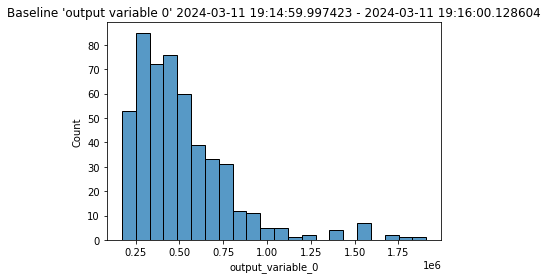

In [16]:
assay_builder_from_dates.baseline_histogram()

### Assay Preview

Now that the baseline is defined, we look at different configuration options and view how the assay baseline and results changes.  Once we determine what gives us the best method of determining model drift, we can create the assay.

#### Analysis List Chart Scores

Analysis List scores show the assay scores for each assay result interval in one chart.  Values that are outside of the alert threshold are colored red, while scores within the alert threshold are green.

Assay chart scores are displayed with the method [`wallaroo.assay.AssayAnalysisList.chart_scores(title: Optional[str] = None)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysisList.chart_scores), with ability to display an optional title with the chart.

The following example shows retrieving the assay results and displaying the chart scores.  From our example, we have two windows - the first should be green, and the second is red showing that values were outside the alert threshold.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()
```

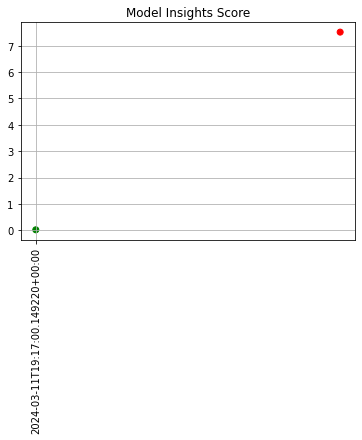

In [18]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()

In [ ]:
#### Analysis Chart

The method `wallaroo.assay.AssayAnalysis.chart()` displays a comparison between the baseline and an interval of inference data.

This is compared to the [Chart Scores](#analysis-list-chart-scores), which is a **list** of all of the inference data split into intervals, while the **Analysis Chart** shows the breakdown of one set of inference data against the baseline.

Score from the [Analysis List Chart Scores](#analysis-list-chart-scores) and each element from the [Analysis List DataFrame](#analysis-list-dataframe) generates 

The following fields are included.

| Field | Type | Description |
|---|---|---|
| **baseline mean** | **Float** | The mean of the baseline values. |
| **window mean** | **Float** | The mean of the window values. |
| **baseline median** | **Float** | The median of the baseline values. |
| **window median** | **Float** | The median of the window values. |
| **bin_mode** | **String** | The binning mode used for the assay. |
| **aggregation** | **String** | The aggregation mode used for the assay. |
| **metric** | **String** | The metric mode used for the assay. |
| **weighted** | **Bool** | Whether the bins were manually weighted. |
| **score** | **Float** | The score from the assay window. |
| **scores** | **List(Float)** | The score from each assay window bin. |
| **index** | **Integer/None** | The window index.  Interactive assay runs are `None`. |

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()
```

baseline mean = 514227.3124375
window mean = 507478.46859375
baseline median = 450623.609375
window median = 445049.296875
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.016941317365585698
scores = [0.002748872195622465, 0.0025104927488832605, 0.005438798089551059, 0.003302949120684397, 0.0023179313444721787, 0.0006222738663723384, 0.0]
index = None


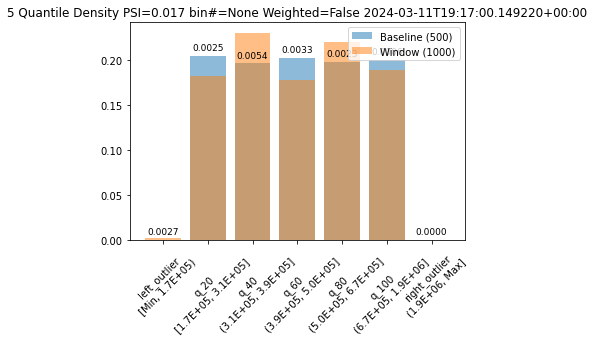

In [19]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

#### Analysis List DataFrame

`wallaroo.assay.AssayAnalysisList.to_dataframe()` returns a DataFrame showing the assay results for each window aka individual analysis.  This DataFrame contains the following fields:

| Field | Type | Description |
|---|---|---|
| **assay_id** | *Integer/None* | The assay id.  Only provided from uploaded and executed assays. |
| **name** | *String/None* | The name of the assay.  Only provided from uploaded and executed assays. |
| **iopath** | *String/None* | The iopath of the assay.  Only provided from uploaded and executed assays. |
| **score** | *Float* | The assay score. |
| **start** | *DateTime* | The DateTime start of the assay window.
| **min** | *Float* | The minimum value in the assay window.
| **max**  | *Float* | The maximum value in the assay window.
| **mean** | *Float* | The mean value in the assay window.
| **median** | *Float* | The median value in the assay window.
| **std** | *Float* | The standard deviation value in the assay window.
| **warning_threshold** | *Float/None* | The warning threshold of the assay window.
| **alert_threshold** | *Float/None* | The alert threshold of the assay window.
| **status** | *String* | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |

For this example, the assay analysis list DataFrame is listed.  

From this tutorial, we should have 2 windows of dta to look at, each one minute apart.  The first window should show `status: OK`, with the second window with the very large house prices will show `status: alert`.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.to_dataframe()
```

In [20]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.to_dataframe()

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,,output variable 0,0.016941,2024-03-11T19:17:00.149220+00:00,1.629850e+05,1908622.50,5.074785e+05,4.450493e+05,258215.325866,None,0.25,Ok
1,None,,output variable 0,7.517112,2024-03-11T19:19:00.149220+00:00,1.902903e+06,2607629.25,2.244347e+06,2.303257e+06,223017.172706,None,0.25,Alert


#### Analysis List Full DataFrame

`wallaroo.assay.AssayAnalysisList.to_full_dataframe()` returns a DataFrame showing all values, including the inputs and outputs from the assay results for each window aka individual analysis.  This DataFrame contains the following fields:


	pipeline_id	warning_threshold	bin_index	created_at


| Field | Type | Description |
|---|---|---|
| **window_start** | *DateTime* | The date and time when the window period began. |
| **analyzed_at** | *DateTime* | The date and time when the assay analysis was performed. |
| **elapsed_millis** | *Integer* | How long the analysis took to perform in milliseconds. |
| **baseline_summary_count** | *Integer* | The number of data elements from the baseline. |
| **baseline_summary_min** | *Float* | The minimum value from the baseline summary. |
| **baseline_summary_max** | *Float* | The maximum value from the baseline summary. |
| **baseline_summary_mean** | *Float* | The mean value of the baseline summary. |
| **baseline_summary_median** | *Float* | The median value of the baseline summary. |
| **baseline_summary_std** | *Float* | The standard deviation value of the baseline summary. |
| **baseline_summary_edges_{0...n}** | *Float* | The baseline summary edges for each baseline edge from 0 to number of edges. |
| **summarizer_type** | *String* | The type of summarizer used for the baseline.  See [`wallaroo.assay_config` for other summarizer types](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/). |
| **summarizer_bin_weights** | *List / None* | If baseline bin weights were provided, the list of those weights.  Otherwise, `None`. |
| **summarizer_provided_edges** | *List / None* | If baseline bin edges were provided, the list of those edges.  Otherwise, `None`. |
| **status** | *String* | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |
| **id** | *Integer/None* | The id for the window aka analysis.  Only provided from uploaded and executed assays. |
| **assay_id** | *Integer/None* | The assay id.  Only provided from uploaded and executed assays. |
| **pipeline_id** | *Integer/None* | The pipeline id.  Only provided from uploaded and executed assays. |
| **warning_threshold** | *Float* | The warning threshold set for the assay. |
| **warning_threshold** | *Float* | The warning threshold set for the assay.
| **bin_index** | *Integer/None* | The bin index for the window aka analysis.|
| **created_at** | *Datetime/None* | The date and time the window aka analysis was generated.  Only provided from uploaded and executed assays. |

For this example, full DataFrame from an assay preview is generated.

From this tutorial, we should have 2 windows of dta to look at, each one minute apart.  The first window should show `status: OK`, with the second window with the very large house prices will show `status: alert`.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.to_full_dataframe()
```

In [21]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.to_full_dataframe()

,window_start,analyzed_at,elapsed_millis,iopath,baseline_summary_count,baseline_summary_min,baseline_summary_max,baseline_summary_mean,baseline_summary_median,baseline_summary_std,...,summarizer_type,summarizer_bin_weights,summarizer_provided_edges,status,id,assay_id,pipeline_id,warning_threshold,bin_index,created_at
0,2024-03-11T19:17:00.149220+00:00,2024-03-11T21:03:15.699380+00:00,798,output variable 0,500,171875.375,1908622.5,514227.312437,450623.609375,277313.851831,...,UnivariateContinuous,None,None,Ok,None,None,None,None,None,None
1,2024-03-11T19:19:00.149220+00:00,2024-03-11T21:03:15.700061+00:00,794,output variable 0,500,171875.375,1908622.5,514227.312437,450623.609375,277313.851831,...,UnivariateContinuous,None,None,Alert,None,None,None,None,None,None


#### Analysis Compare Basic Stats

The method `wallaroo.assay.AssayAnalysis.compare_basic_stats` returns a DataFrame comparing one set of inference data against the baseline.

This is compared to the [Analysis List DataFrame](#analysis-list-dataframe), which is a **list** of all of the inference data split into intervals, while the **Analysis Compare Basic Stats** shows the breakdown of one set of inference data against the baseline.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].compare_basic_stats()
```

In [22]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].compare_basic_stats()

,Baseline,Window,diff,pct_diff
count,500.0,1000.0,500.000000,100.000000
min,171875.375,162984.96875,-8890.406250,-5.172589
max,1908622.5,1908622.5,0.000000,0.000000
mean,514227.312437,507478.468594,-6748.843844,-1.312424
median,450623.609375,445049.296875,-5574.312500,-1.237022
std,277313.851831,258215.325866,-19098.525965,-6.886972
start,2024-03-11T19:14:59.997423+00:00,2024-03-11T19:17:00.149220+00:00,NaN,NaN
end,2024-03-11T19:16:00.128604+00:00,2024-03-11T19:18:00.149220+00:00,NaN,NaN


#### Configure Assays

Before creating the assay, **configure** the assay and continue to preview it until the best method for detecting drift is set.  The following options are available.

##### Score Metric

The `score` is a distance between the baseline and the analysis window.  The larger the score, the greater the difference between the baseline and the analysis window.  The following methods are provided determining the score:

* `PSI` (*Default*) - Population Stability Index (PSI).
* `MAXDIFF`: Maximum difference between corresponding bins.
* `SUMDIFF`: Mum of differences between corresponding bins.

The metric type used is updated with the [`wallaroo.assay_config.AssayBuilder.add_metric(metric: wallaroo.assay_config.Metric)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_metric) method.

The following three charts use each of the metrics.  Note how the scores change based on the score type used.

For this example, we'll show how to set the metric to PSI.  Use the sample code to display the score metric in `MAXDIFF` and `SUMDIFF`.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

# set metric PSI mode
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.PSI)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()
```

baseline mean = 514227.3124375
window mean = 507478.46859375
baseline median = 450623.609375
window median = 445049.296875
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.016941317365585698
scores = [0.002748872195622465, 0.0025104927488832605, 0.005438798089551059, 0.003302949120684397, 0.0023179313444721787, 0.0006222738663723384, 0.0]
index = None


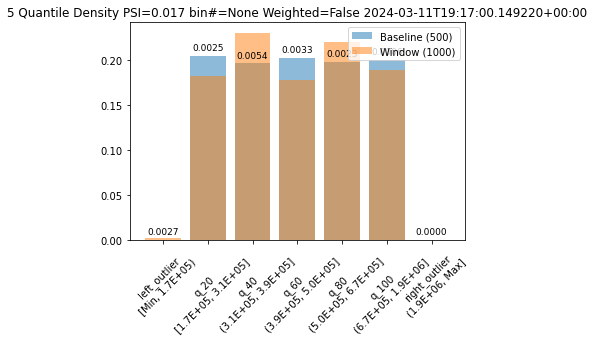

In [23]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

# set metric PSI mode
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.PSI)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

baseline mean = 514227.3124375
window mean = 507478.46859375
baseline median = 450623.609375
window median = 445049.296875
bin_mode = Quantile
aggregation = Density
metric = MaxDiff
weighted = False
score = 0.034
scores = [0.002, 0.021999999999999992, 0.034, 0.025000000000000026, 0.021999999999999992, 0.01100000000000001, 0.0]
index = 2


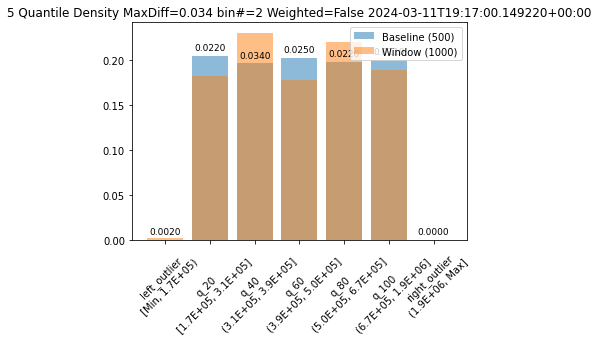

In [24]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

# set metric MAXDIFF mode
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.MAXDIFF)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

baseline mean = 514227.3124375
window mean = 507478.46859375
baseline median = 450623.609375
window median = 445049.296875
bin_mode = Quantile
aggregation = Density
metric = SumDiff
weighted = False
score = 0.05800000000000001
scores = [0.002, 0.021999999999999992, 0.034, 0.025000000000000026, 0.021999999999999992, 0.01100000000000001, 0.0]
index = None


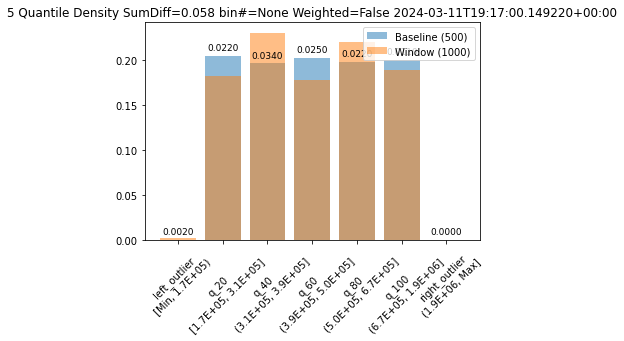

In [25]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

# set metric SUMDIFF mode
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.SUMDIFF)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

##### Alert Threshold

Assay alert thresholds are modified with the [`wallaroo.assay_config.AssayBuilder.add_alert_threshold(alert_threshold: float)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/) method.  By default alert thresholds are `0.1`.

The following example updates the alert threshold to `0.5`.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


assay_builder_from_dates.add_alert_threshold(0.5)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.to_dataframe()
```

In [27]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


assay_builder_from_dates.add_alert_threshold(0.5)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.to_dataframe()

,assay_id,name,iopath,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,,output variable 0,0.016941,2024-03-11T19:17:00.149220+00:00,1.629850e+05,1908622.50,5.074785e+05,4.450493e+05,258215.325866,None,0.5,Ok
1,None,,output variable 0,7.517112,2024-03-11T19:19:00.149220+00:00,1.902903e+06,2607629.25,2.244347e+06,2.303257e+06,223017.172706,None,0.5,Alert


##### Number of Bins

Number of bins sets how the baseline data is partitioned.  The total number of bins includes the set number plus the left_outlier and the right_outlier, so the total number of bins will be the total set + 2.

The number of bins is set with the [`wallaroo.assay_config.assay_builder.add_num_bins(num_bins: int)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_num_bins) method.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


# Set the number of bins
# update number of bins here
assay_builder_from_dates.summarizer_builder.add_num_bins(10)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()
```

baseline mean = 514227.3124375
window mean = 507478.46859375
baseline median = 450623.609375
window median = 445049.296875
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.03313589216215494
scores = [0.002748872195622465, 0.009480180782546805, 0.0004736105393167021, 0.0009716374845364762, 0.005257285585504427, 0.0006670528715124097, 0.0030994664654972236, 3.883617171420307e-05, 0.003784839992770567, 0.005466149904566996, 0.0011479601685666688, 0.0]
index = None


/opt/conda/lib/python3.9/site-packages/wallaroo/assay.py:317: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=edge_names, rotation=45)


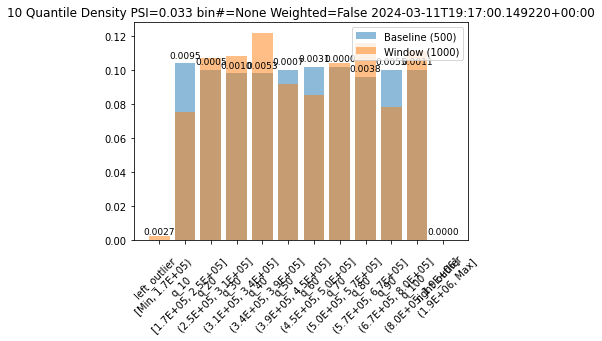

In [28]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


# Set the number of bins
# update number of bins here
assay_builder_from_dates.summarizer_builder.add_num_bins(10)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

##### Binning Mode

Binning Mode defines how the bins are separated.  Binning modes are modified through the `wallaroo.assay_config.UnivariateContinousSummarizerBuilder.add_bin_mode(bin_mode: bin_mode: wallaroo.assay_config.BinMode, edges: Optional[List[float]] = None)`.

Available `bin_mode` values from `wallaroo.assay_config.Binmode` are the following:

* `QUANTILE` (*Default*): Based on percentages. If `num_bins` is 5 then quintiles so bins are created at the 20%, 40%, 60%, 80% and 100% points.
* `EQUAL`: Evenly spaced bins where each bin is set with the formula `min - max / num_bins`
* `PROVIDED`: The user provides the edge points for the bins.

If `PROVIDED` is supplied, then a List of float values must be provided for the `edges` parameter that matches the number of bins.

For the workshop, use the code below and show first the `QUANTILE` and then the `EQUAL` binning modes.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


# update binning mode here
assay_builder_from_dates.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.QUANTILE)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()
```

baseline mean = 514227.3124375
window mean = 507478.46859375
baseline median = 450623.609375
window median = 445049.296875
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.016941317365585698
scores = [0.002748872195622465, 0.0025104927488832605, 0.005438798089551059, 0.003302949120684397, 0.0023179313444721787, 0.0006222738663723384, 0.0]
index = None


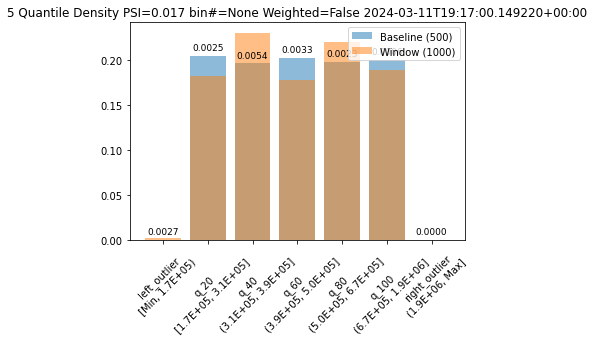

In [29]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


# update binning mode here
assay_builder_from_dates.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.QUANTILE)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

baseline mean = 514227.3124375
window mean = 507478.46859375
baseline median = 450623.609375
window median = 445049.296875
bin_mode = Equal
aggregation = Density
metric = PSI
weighted = False
score = 0.009673567227025998
scores = [0.002748872195622465, 0.0007819886232270504, 0.0024855698992845778, 0.00015655725951171053, 0.0016271120021731395, 0.0018734672472070536, 0.0]
index = None


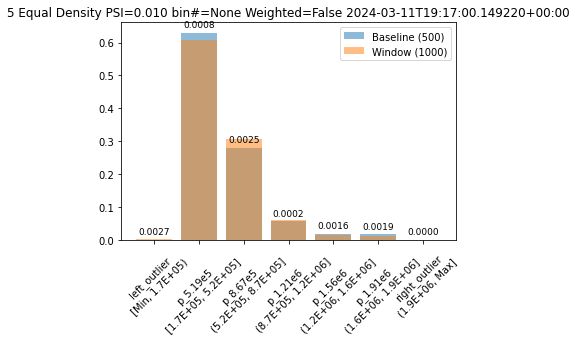

In [30]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


# update binning mode here
assay_builder_from_dates.summarizer_builder.add_bin_mode(wallaroo.assay_config.BinMode.EQUAL)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

##### Aggregation Options

Assay aggregation options are modified with the [`wallaroo.assay_config.AssayBuilder.add_aggregation(aggregation: wallaroo.assay_config.Aggregation)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#UnivariateContinousSummarizerBuilder.add_aggregation) method.  The following options are provided:

* `Aggregation.DENSITY` (*Default*): Count the number/percentage of values that fall in each bin. 
* `Aggregation.CUMULATIVE`: Empirical Cumulative Density Function style, which keeps a cumulative count of the values/percentages that fall in each bin.

Use the code block below to show the difference in the aggregation options.  Start with `DENSITY` and then show `CUMULATIVE`.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


assay_builder_from_dates.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.DENSITY)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()
```

baseline mean = 514227.3124375
window mean = 507478.46859375
baseline median = 450623.609375
window median = 445049.296875
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.016941317365585698
scores = [0.002748872195622465, 0.0025104927488832605, 0.005438798089551059, 0.003302949120684397, 0.0023179313444721787, 0.0006222738663723384, 0.0]
index = None


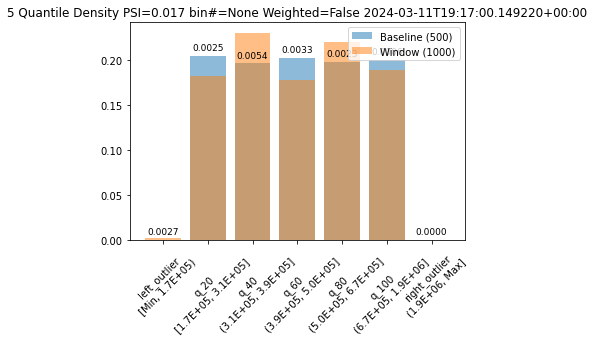

In [31]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


assay_builder_from_dates.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.DENSITY)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

baseline mean = 514227.3124375
window mean = 507478.46859375
baseline median = 450623.609375
window median = 445049.296875
bin_mode = Quantile
aggregation = Cumulative
metric = PSI
weighted = False
score = 0.05799999999999997
scores = [0.002, 0.01999999999999999, 0.013999999999999955, 0.01100000000000001, 0.01100000000000001, 0.0, 0.0]
index = None


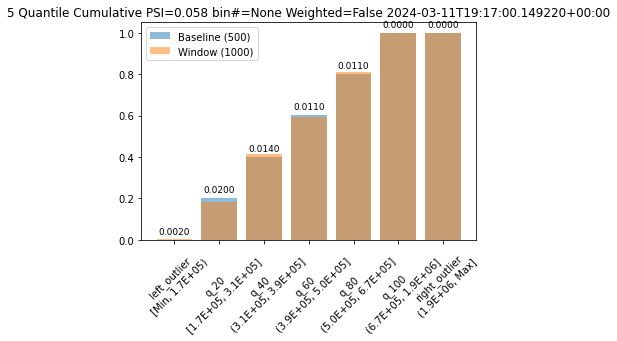

In [32]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


assay_builder_from_dates.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.CUMULATIVE)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

##### Inference Interval and Inference Width

The inference interval aka window interval sets how often to run the assay analysis.  This is set from the [`wallaroo.assay_config.AssayBuilder.window_builder.add_interval`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_interval) method to collect data expressed in time units:  "hours=24", "minutes=1", etc.

For example, with an interval of 1 minute, the assay collects data every minute.  Within an hour, 60 intervals of data is collected.

We can adjust the interval and see how the assays change based on how **frequently** they are run.

The width sets the time period from the [`wallaroo.assay_config.AssayBuilder.window_builder.add_width`](/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#WindowBuilder.add_width) method to collect data expressed in time units:  "hours=24", "minutes=1", etc.

For example, an interval of 1 minute and a width of 1 minute collects 1 minutes worth of data every minute.  An interval of 1 minute with a width of 5 minutes collects 5 minute of inference data every minute.

By default, the interval and width is **24 hours**.

Use the code block below and adjust the interval and width to 5 minutes.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()
```

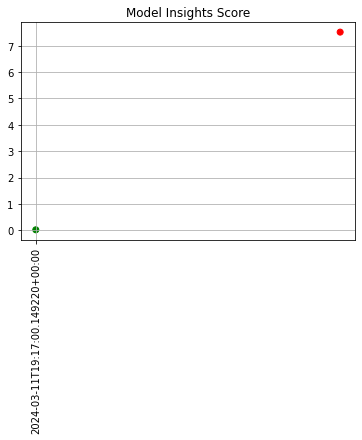

In [35]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()

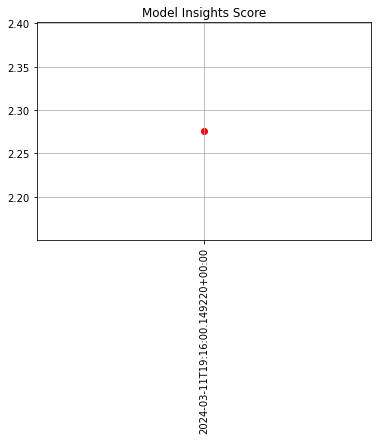

In [36]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )


assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=5).add_interval(minutes=5).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()

### Create Assay

With the assay previewed and configuration options determined, we officially create it by uploading it to the Wallaroo instance.

Once it is uploaded, the assay runs an analysis based on the window width, interval, and the other settings configured.

Assays are uploaded with the `wallaroo.assay_config.upload()` method. This uploads the assay into the Wallaroo database with the configurations applied and returns the assay id. Note that assay names **must be unique across the Wallaroo instance**; attempting to upload an assay with the same name as an existing one will return an error.

`wallaroo.assay_config.upload()` returns the assay id for the assay.

Typically we would just call `wallaroo.assay_config.upload()` after configuring the assay.  For the example below, we will perform the complete configuration in one window to show all of the configuration steps at once before creating the assay.

```python
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

# add other options
assay_builder_from_dates.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.CUMULATIVE)
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.MAXDIFF)
assay_builder_from_dates.add_alert_threshold(0.5)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=5).add_interval(minutes=5).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()

# not doing for the workshop so we don't have 50 assays running
# assay_id = assay_builder_from_dates.upload()

# wait 65 seconds for the first analysis run performed
time.sleep(65)
```



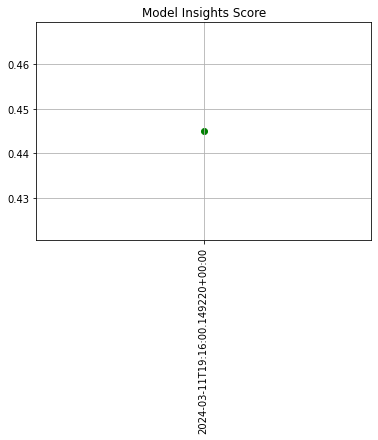

In [37]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = ( wl.build_assay('sample assay from baseline_date', 
                                            pipeline, 
                                            model_name, 
                                            baseline_start=assay_baseline_start, 
                                            baseline_end=assay_baseline_end)
                                            .add_iopath("output variable 0")
                           )

# add other options
assay_builder_from_dates.summarizer_builder.add_aggregation(wallaroo.assay_config.Aggregation.CUMULATIVE)
assay_builder_from_dates.summarizer_builder.add_metric(wallaroo.assay_config.Metric.MAXDIFF)
assay_builder_from_dates.add_alert_threshold(0.5)

assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=5).add_interval(minutes=5).add_start(assay_window_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()

# not doing for the workshop so we don't have 50 assays running
assay_id = assay_builder_from_dates.upload()

# wait 65 seconds for the first analysis run performed
time.sleep(65)


### Get Assay Results

Once an assay is created the assay runs an analysis based on the window width, interval, and the other settings configured.

Assay results are retrieved with the `wallaroo.client.get_assay_results` method, which takes the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_id** | *Integer* (*Required*) | The numerical id of the assay. |
| **start** | *Datetime.Datetime* (*Required*) | The start date and time of historical data from the pipeline to start analyses from. |
| **end** | *Datetime.Datetime* (*Required*) | The end date and time of historical data from the pipeline to limit analyses to. |

* **IMPORTANT NOTE**:  This process requires that additional historical data is generated from the time the assay is created to when the results are available. To add additional inference data, use the [Assay Test Data](#assay-test-data) section above.

### List and Retrieve Assay

If the assay id is not already known, it is retrieved from the `wallaroo.client.list_assays()` method.  Select the assay to retrieve data for and retrieve its id with `wallaroo.assay.Assay._id` method.

Use `list_assays()` to show the current assays.

```python
wl.list_assays()
```

In [5]:
wl.list_assays()

name,active,status,warning_threshold,alert_threshold,pipeline_name
sample assay from baseline_date,True,"{""run_at"": ""2024-03-11T21:28:54.497495392+00:00"", ""num_ok"": 1, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.5,houseprice-estimator


In [6]:
# retrieve a specific assay
retrieved_assay = wl.list_assays()[0]

### Pause and Resume Assay

Assays are paused and started with the `wallaroo.assay.Assay.turn_off` and `wallaroo.assay.Assay.turn_on` methods.

For the following, we retrieve an assay from the wallaroo instance and pause it, then list the assays to verify its setting `Active` is `False`.

In [10]:
display(wl.list_assays())
retrieved_assay = wl.list_assays()[0]

name,active,status,warning_threshold,alert_threshold,pipeline_name
sample assay from baseline_date,True,"{""run_at"": ""2024-03-11T21:28:54.497495392+00:00"", ""num_ok"": 1, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.5,houseprice-estimator


Now we pause the assay, and show the assay list to verify it is no longer active.

In [13]:
retrieved_assay.turn_off()
display(wl.list_assays())

name,active,status,warning_threshold,alert_threshold,pipeline_name
sample assay from baseline_date,False,"{""run_at"": ""2024-03-11T21:28:54.497495392+00:00"", ""num_ok"": 1, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.5,houseprice-estimator


We resume the assay and verify its setting `Active` is `True`.

In [12]:
retrieved_assay.turn_on()
display(wl.list_assays())

name,active,status,warning_threshold,alert_threshold,pipeline_name
sample assay from baseline_date,True,"{""run_at"": ""2024-03-11T21:28:54.497495392+00:00"", ""num_ok"": 1, ""num_warnings"": 0, ""num_alerts"": 0}",None,0.5,houseprice-estimator


## Cleaning up.

Now that the workshop is complete, don't forget to undeploy your pipeline to free up the resources.


In [14]:
# blank space to undeploy your pipeline

pipeline.undeploy()


name,houseprice-estimator
created,2024-03-11 17:58:59.194422+00:00
last_updated,2024-03-12 14:20:36.802000+00:00
deployed,False
tags,
versions,"88fa845d-0592-44df-8c23-3c8a5d888918, 77ad5fac-733b-40aa-8471-2b623731a1c2, e2c02684-b936-4eaa-ae22-16cc425ac1a7, 90680a22-b46c-4c4c-9c93-cecf87860321, d7ae395c-c5db-41aa-abfa-37aab4050924, e2c920d7-f993-4974-86ff-fdb5230ff590"
steps,house-price-prime


You have now walked through setting up a basic assay and running it over historical data.

## Congratulations!

In this workshop you have:

* Created an assay baseline.
* Previewed the assay based on different configurations.
* Uploaded the assay.

Great job!